<a href="https://colab.research.google.com/github/OrsonTyphanel93/adversarial-robustness-toolbox/blob/patch-5/Copie_de_Update_ART_1_18_Bayesian_diffusion_models_backdoor_Backdoor_attack_HuggingFace_Model_Automatic_Speech_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook demonstrates the feasibility of Bayesian-diffusion models backdoor on HugginFace (Automatic Speech Recognition) audio models. **

In [ ]:
'''
install library which is not already installed
'''
!pip3 install pymc
!pip install torch torchvision
!pip install transformers
!pip3 install adversarial-robustness-toolbox tensorflow Keras matplotlib ipywidgets
#!pip install tensorflow==2.15

In [2]:
import logging
import numpy as np
logging.basicConfig(level=logging.INFO)  # Set the desired logging level


class CacheTrigger:
    """
    Adds an audio backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        trigger: np.ndarray,
        random: bool = False,
        shift: int = 0,
        imperceptibility: float = 0.1,
    ):
        """
        Initialize a CacheTrigger instance.
        :param trigger: Loaded audio trigger
        :param random: Flag indicating whether the trigger should be randomly placed.
        :param shift: Number of samples from the left to shift the trigger (when not using random placement).
        :param imperceptibility: Scaling factor for mixing the trigger.
        """
        if not isinstance(trigger, np.ndarray):
            raise TypeError("Trigger must be a NumPy array.")
        if not 0 <= imperceptibility <= 1:
            raise ValueError("Imperceptibility must be between 0 and 1.")

        self.trigger = trigger
        self.scaled_trigger = self.trigger * imperceptibility
        self.random = random
        self.shift = shift
        self.imperceptibility = imperceptibility

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Insert a backdoored trigger into audio.
        :param x: N x L matrix or length L array, where N is the number of examples, L is the length in number of samples.
                  x is in the range [-1, 1].
        :return: Backdoored audio.
        """
        if len(x.shape) == 2:
            return np.array([self.insert(single_audio) for single_audio in x])

        if len(x.shape) != 1:
            raise ValueError(f"Invalid array shape: {x.shape}")

        original_dtype = x.dtype
        audio = np.copy(x)
        length = audio.shape[0]
        bd_length = self.trigger.shape[0]

        if bd_length > length:
            raise ValueError("Backdoor audio does not fit inside the original audio.")

        if self.random:
            shift = np.random.randint(length - bd_length)
        else:
            shift = self.shift

        if shift + bd_length > length:
            raise ValueError("Shift + Backdoor length is greater than audio's length.")

        audio[shift: shift + bd_length] += self.scaled_trigger[:bd_length]
        audio = np.clip(audio, -1.0, 1.0)
        return audio.astype(original_dtype)


class CacheAudioTrigger(CacheTrigger):
    """
    Adds an audio backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        sampling_rate: int = 16000,
        backdoor_path: str = "/content/triggers_clapping.wav",
        duration: float = None,
        imperceptibility: float = 0.1,
        scale: float = 0.1,  # Add scale parameter here
        **kwargs,
    ):
        """
        Initialize a CacheAudioTrigger instance.
        :param sampling_rate: Positive integer denoting the sampling rate for x.
        :param backdoor_path: The path to the audio to insert as a trigger.
        :param duration: Duration of the trigger in seconds. Default `None` if the full trigger is to be used.
        :param imperceptibility: Scaling factor for the imperceptibility effect.
        :param scale: Scale factor for the trigger.
        """
        try:
            trigger, bd_sampling_rate = librosa.load(backdoor_path, mono=True, sr=None, duration=duration)
        except (FileNotFoundError, IsADirectoryError) as e:
            logging.error(f"Error loading backdoor audio: {str(e)}")
            raise

        if sampling_rate != bd_sampling_rate:
            logging.warning(
                f"Backdoor sampling rate {bd_sampling_rate} does not match with the sampling rate provided. "
                "Resampling the backdoor to match the sampling rate."
            )
            try:
                trigger, _ = librosa.load(backdoor_path, mono=True, sr=sampling_rate, duration=duration)
            except (FileNotFoundError, IsADirectoryError) as e:
                logging.error(f"Error loading and resampling backdoor audio: {str(e)}")
                raise

        self.scale = scale  # Store scale locally
        super().__init__(trigger, imperceptibility=imperceptibility, **kwargs)

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Override the insert method to incorporate the scale factor.
        """
        audio = super().insert(x)
        return audio * self.scale  # Apply the scale factor after insertion


class CacheToneTrigger(CacheTrigger):
    """
    Adds a tone backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        sampling_rate: int = 16000,
        frequency: int = 440,
        duration: float = 0.1,
        imperceptibility: float = 0.1,
        scale: float = 0.25,  # Add scale parameter here
        **kwargs,
    ):
        """
        Initialize a CacheToneTrigger instance.
        :param sampling_rate: Positive integer denoting the sampling rate for x.
        :param frequency: Frequency of the tone to be added.
        :param duration: Duration of the tone to be added.
        :param imperceptibility: Scaling factor for the imperceptibility effect.
        :param scale: Scale factor for the trigger.
        """
        trigger = librosa.tone(frequency, sr=sampling_rate, duration=duration)
        self.scale = scale  # Store scale locally
        super().__init__(trigger, imperceptibility=imperceptibility, **kwargs)

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Override the insert method to incorporate the scale factor.
        """
        audio = super().insert(x)
        return audio * self.scale  # Apply the scale factor after insertion

In [3]:
import pymc as pm
from IPython.display import Audio, Image
import glob
import random
from tqdm  import tqdm
from scipy.io import wavfile
import numpy as np
import librosa

import tensorflow as tf
import IPython
from IPython import display
import os, sys
import pathlib
%matplotlib inline

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art import config
from art.estimators.classification import TensorFlowV2Classifier

import matplotlib.pyplot as plt
import torch
import torchvision
import transformers

import warnings
warnings.filterwarnings("ignore")

tqdm.pandas()
from art.estimators.classification.hugging_face import HuggingFaceClassifierPyTorch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the seed value for experiment reproducibility.
seed = 72
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
# install datasets
%%capture
!pip install datasets==1.18.3
from datasets import load_dataset

In [5]:
# Let's import the library. We typically only need at most two methods:
from datasets import list_datasets, load_dataset
from pprint import pprint

In [6]:
from tqdm.notebook import tqdm
import os; import psutil; import timeit

#loading the dataset from 'datasets' library
timit = load_dataset("timit_asr")

Downloading:   0%|          | 0.00/2.40k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset timit_asr downloaded and prepared to /root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/b11b576ddcccbcefa7c9f0c4e6c2a43756f3033adffe0fb686aa61043d0450ad. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from typing import Callable, Any
import matplotlib.pyplot as plt

class YangMillsSimulator:
    def __init__(self, alpha: np.ndarray, beta: np.ndarray, sigma: np.ndarray, noise_dist: Callable[[Any], np.ndarray], particle_creation_probability: float = 0.1):
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.noise_dist = noise_dist
        self.particle_creation_probability = particle_creation_probability

    def calculate_mass_gap(self, t: int) -> float:
        return np.sqrt(self.alpha[t])

    def simulate_particle_creation(self, x: float, t: int, temperature: float, particles: np.ndarray) -> float:
        mass_gap = self.calculate_mass_gap(t)
        adjusted_probability = self.particle_creation_probability * np.exp(-mass_gap / temperature)
        if not np.random.rand() < adjusted_probability:
            return 0.0

        G = 6.67430e-11 # Gravitational constant
        softening = 1e-9 # Softening parameter to avoid numerical issues
        forces = np.zeros_like(particles)
        for i in range(len(particles)):
            for j in range(i+1, len(particles)):
                r = particles[j] - particles[i]
                r_norm = np.linalg.norm(r)
                if r_norm > 0:
                    force = G * particles[i] * particles[j] / r_norm**2
                    forces[i] += force
                    forces[j] -= force

        particles += forces * self.noise_dist(self.beta[t])

        return mass_gap * self.noise_dist(self.beta[t])

    def simulate_lattice(self, lattice_size: int, temperature: float) -> np.ndarray:
        lattice = np.zeros((lattice_size, lattice_size))
        for i in range(lattice_size):
            for j in range(lattice_size):
                particle = self.simulate_particle_creation(i, j, temperature, lattice)
                lattice[i, j] = particle
        return lattice

    def simulate_interactions(self, lattice: np.ndarray, temperature: float) -> np.ndarray:
        # Simulate interactions based on the current state of the lattice
        # This is a placeholder for more complex interaction calculations
        return lattice

    def run_simulation(self, lattice_size: int, temperature: float, steps: int):
        lattice = self.simulate_lattice(lattice_size, temperature)
        for step in range(steps):
            lattice = self.simulate_interactions(lattice, temperature)
        return lattice

    def parallel_simulation(self, lattice_size: int, temperature: float, steps: int, num_processes: int):
        with ProcessPoolExecutor(num_processes) as executor:
            results = list(executor.map(self.run_simulation, [(lattice_size, temperature, steps) for _ in range(num_processes)]))
        return np.mean(results, axis=0)

    def visualize_lattice(self, lattice: np.ndarray):
        plt.imshow(lattice, cmap='hot', interpolation='nearest')
        plt.colorbar(label='Particle Density')
        plt.title('Lattice Visualization')
        plt.show()




In [15]:
from IPython import display
import tensorflow as tf
import librosa
import numpy as np
import os

# Extracting relevant information from the dataset
file_info = timit['train']['file']
speaker_id_info = timit['train']['speaker_id']

# Grouping each audio file according to the 'speaker_id' attribute
grouped_data = {}

for i in range(len(file_info)):
    speaker_id = speaker_id_info[i]
    if speaker_id not in grouped_data:
        grouped_data[speaker_id] = []

    file_data = {
        'file': file_info[i],
        'speaker_id': speaker_id_info[i],
    }

    grouped_data[speaker_id].append(file_data)

# If you want to visualize the audio, you can modify the code as follows:
all_files = [file_data['file'] for files in grouped_data.values() for file_data in files]

# Shuffle the files
filenames = tf.random.shuffle(all_files).numpy()
example_files = filenames[:2000]

def get_audio_clips_and_labels(file_paths):
    audio_samples = []
    audio_labels = []
    for file_path in file_paths:
        audio, _ = librosa.load(file_path, sr=16000)
        audio = audio[:16000]
        if len(audio) < 16000:
            audio_padded = np.zeros(16000)
            audio_padded[:len(audio)] = audio
            audio = audio_padded
        label = tf.strings.split(
                        input=file_path,
                        sep=os.path.sep)[-2]

        audio_samples.append(audio)
        audio_labels.append(label.numpy().decode("utf-8") )
    return np.stack(audio_samples), np.stack(audio_labels)


x_audio, y_audio = get_audio_clips_and_labels(example_files)

# Displaying information about the first few audio clips
for i in range(3):
    print('Speaker ID Label:', y_audio[i])
    display.display(display.Audio(x_audio[i], rate=16000))

Speaker ID Label: FSLS0


Speaker ID Label: MTBC0


Speaker ID Label: MNET0


# Backdoor attack Speech : BacKBayDiffMod Yang-Mills

#### with "gauge_group = 'SU(3)'" group

In [36]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from typing import Callable, Any

class YangMillsSimulator:
    def __init__(self, alpha: np.ndarray, beta: np.ndarray, sigma: np.ndarray, noise_dist: Callable[[Any], np.ndarray], particle_creation_probability: float = 0.1):
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.noise_dist = noise_dist
        self.particle_creation_probability = particle_creation_probability
        self.gauge_group = 'SU(3)' # Example of a gauge group

    def calculate_mass_gap(self, t: int) -> float:
        return np.sqrt(self.alpha[t])

    def simulate_particle_creation(self, x: float, t: int, temperature: float) -> float:
        mass_gap = self.calculate_mass_gap(t)
        adjusted_probability = self.particle_creation_probability * np.exp(-mass_gap / temperature)
        if not np.random.rand() < adjusted_probability:
            return 0.0
        return mass_gap * self.noise_dist(self.beta[t])

    def simulate_lattice(self, lattice_size: int, temperature: float) -> np.ndarray:
        lattice = np.zeros((lattice_size, lattice_size))
        for i in range(lattice_size):
            for j in range(lattice_size):
                particle = self.simulate_particle_creation(i, j, temperature)
                lattice[i, j] = particle
        return lattice

    def simulate_interactions(self, lattice: np.ndarray, temperature: float) -> np.ndarray:
        # Placeholder for more complex interaction calculations
        # For example, we could simulate the interaction of particles based on their positions and the gauge group dynamics
        # This is a simplified example and would need to be expanded for a real simulation
        return lattice

    def run_simulation(self, lattice_size: int, temperature: float, steps: int):
        lattice = self.simulate_lattice(lattice_size, temperature)
        for step in range(steps):
            lattice = self.simulate_interactions(lattice, temperature)
            # Optionally, update parameters like alpha, beta, sigma based on the current state
        return lattice

    def parallel_simulation(self, lattice_size: int, temperature: float, steps: int, num_processes: int):
        with ProcessPoolExecutor(num_processes) as executor:
            results = list(executor.map(self.run_simulation, [(lattice_size, temperature, steps) for _ in range(num_processes)]))
        return np.mean(results, axis=0)


#### without "gauge_group = 'SU(3)" group

In [19]:
#GOOD CODE
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
from typing import Callable, Any

class YangMillsSimulator:
    def __init__(self, alpha: np.ndarray, beta: np.ndarray, sigma: np.ndarray, noise_dist: Callable[[Any], np.ndarray], particle_creation_probability: float = 0.1):
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.noise_dist = noise_dist
        self.particle_creation_probability = particle_creation_probability

    def calculate_mass_gap(self, t: int) -> float:
        return np.sqrt(self.alpha[t])

    def simulate_particle_creation(self, x: float, t: int, temperature: float) -> float:
        # Adjust particle creation probability based on temperature and mass gap
        mass_gap = self.calculate_mass_gap(t)
        adjusted_probability = self.particle_creation_probability * np.exp(-mass_gap / temperature)
        if not np.random.rand() < adjusted_probability:
            return 0.0
        return mass_gap * self.noise_dist(self.beta[t])

    def simulate_lattice(self, lattice_size: int, temperature: float) -> np.ndarray:
        lattice = np.zeros((lattice_size, lattice_size))
        for i in range(lattice_size):
            for j in range(lattice_size):
                particle = self.simulate_particle_creation(i, j, temperature)
                lattice[i, j] = particle
        return lattice

    def simulate_interactions(self, lattice: np.ndarray, temperature: float) -> np.ndarray:
        # Simulate interactions based on the current state of the lattice
        # This is a placeholder for more complex interaction calculations
        return lattice

    def run_simulation(self, lattice_size: int, temperature: float, steps: int):
        lattice = self.simulate_lattice(lattice_size, temperature)
        for step in range(steps):
            lattice = self.simulate_interactions(lattice, temperature)
            # Optionally, update parameters like alpha, beta, sigma based on the current state
        return lattice

    def parallel_simulation(self, lattice_size: int, temperature: float, steps: int, num_processes: int):
        with ProcessPoolExecutor(num_processes) as executor:
            results = list(executor.map(self.run_simulation, [(lattice_size, temperature, steps) for _ in range(num_processes)]))
        return np.mean(results, axis=0)

    def visualize_lattice(self, lattice: np.ndarray):
        plt.imshow(lattice, cmap='hot', interpolation='nearest')
        plt.colorbar(label='Particle Density')
        plt.title('Lattice Visualization')
        plt.show()


## Data poisoning

You can skip this notepad if you wish, as there is no need to poison the database, because even without poisoning, the backdoor attack will remain imperceptible and 100% effective.

## Yang-Mills Simulator

In [38]:
#GOOD CODE
from typing import Any, Callable, Optional, Union, Tuple
import numpy as np
import scipy.stats as stats
import pymc as pm
import matplotlib.pyplot as plt

# Constants for magic numbers
DEFAULT_FLIP_PROB = 0.5
DEFAULT_TRIGGER_ALPHA = 0.1
DEFAULT_POISON_RATE = 0.01

step_kwargs = {
    "nuts": {
        "max_treedepth": 10, # Adjust this value as needed
        # Add other NUTS-specific arguments here if necessary
    }
}

class PoisoningAttackCleanLabelBackdoor:
    def __init__(
        self,
        trigger_func: Callable,
        target_label: Union[int, str, np.ndarray],
        dirty_label: Union[int, str, np.ndarray],
        alpha: np.ndarray,
        beta: np.ndarray,
        sigma: np.ndarray,
        flip_prob: float = DEFAULT_FLIP_PROB,
        trigger_alpha: float = DEFAULT_TRIGGER_ALPHA,
        poison_rate: float = DEFAULT_POISON_RATE,
        backdoor_trigger: Optional[Union[int, str, np.ndarray]] = None,
        backdoor_target: Optional[Union[int, str, np.ndarray]] = None,
        training_dataset: Optional[np.ndarray] = None,
        training_params: Optional[dict] = None,
        prior_mean: float = 0,
        prior_std: float = 1,
        noise_dist: Callable[[Any], np.ndarray] = np.random.normal # Added noise_dist initialization
    ) -> None:
        self.trigger_func = trigger_func
        self.target_label = target_label
        self.dirty_label = dirty_label
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.flip_prob = flip_prob
        self.trigger_alpha = trigger_alpha
        self.poison_rate = poison_rate
        self.backdoor_trigger = backdoor_trigger if backdoor_trigger is not None else 0
        self.backdoor_target = backdoor_target
        self.training_dataset = training_dataset
        self.training_params = training_params
        self.prior_mean = prior_mean
        self.prior_std = prior_std
        self.prior = stats.norm(loc=prior_mean, scale=prior_std)
        self.noise_dist = noise_dist # Ensure noise_dist is initialized


    def poison(
        self,
        x_audio: np.ndarray,
        y: Optional[np.ndarray] = None,
        broadcast: bool = False,
        random_seed: Optional[int] = None
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Apply the poisoning attack to the given audio data.
        """
        if y is None or not np.any(np.isin(self.target_label, y)):
            return x_audio, y

        num_poison = int(len(x_audio) * self.poison_rate)

        poisoned_labels = np.full((num_poison,), self.dirty_label)

        if broadcast:
            y_attack = np.broadcast_to(y, (x_audio.shape[0], y.shape[0]))
        else:
            y_attack = np.copy(y)

        np.random.seed(random_seed)

        for i in range(num_poison):
            trigger_pattern = self.trigger_func(x_audio[i])

            if np.random.rand() < self.flip_prob:
                poisoned_labels[i] = self.target_label[0]

            x_audio[i] = (1 - self.trigger_alpha) * x_audio[i] + self.trigger_alpha * trigger_pattern

        try:
            # Calculate the sample mean and variance using NumPy functions
            sample_mean = np.mean(x_audio)
            sample_variance = np.var(x_audio)

            # Update the prior with the sample statistics
            self.prior = stats.norm(loc=sample_mean, scale=np.sqrt(sample_variance))

            # Perform Bayesian sampling
            _ = self._bayesian_sampling_diffusion_model(T=10, alpha=np.linspace(0.1, 1.0, 10), beta=np.linspace(0.2, 2.0, 10), sigma=np.linspace(0.3, 3.0, 10), noise_dist=np.random.normal)

        except Exception as e:
            print(f"An error occurred during poisoning: {e}")
            raise

        return x_audio, poisoned_labels

    def _bayesian_sampling_diffusion_model(
        self,
        T: int,
        alpha: np.ndarray,
        beta: np.ndarray,
        sigma: np.ndarray,
        noise_dist: Callable[[Any], np.ndarray]
    ) -> pm.backends.base.MultiTrace:
        """
        Perform bad diffusion sampling for a given time period, alpha, beta, sigma, and noise distribution.

        Parameters:
        - T (int): Time period for sampling.
        - alpha (np.ndarray): Array of alpha values.
        - beta (np.ndarray): Array of beta values.
        - sigma (np.ndarray): Array of sigma values.
        - noise_dist (Callable[[Any], np.ndarray]): Noise distribution function.

        Returns:
        pm.backends.base.MultiTrace: Trace of the bad diffusion sampling.
        """
        assert isinstance(T, int), "Expected T to be an integer"
        assert isinstance(alpha, np.ndarray) and alpha.ndim == 1, "Expected alpha to be a 1D numpy array"
        assert isinstance(beta, np.ndarray) and beta.ndim == 1, "Expected beta to be a 1D numpy array"
        assert isinstance(sigma, np.ndarray) and sigma.ndim == 1, "Expected sigma to be a 1D numpy array"
        assert callable(noise_dist), "Expected noise_dist to be a callable function"

        try:
            with pm.Model() as model:
                # Initialize the state variable x_T
                x_T = pm.Normal('x_T', mu=self.prior.rvs() if np.random.rand() < self.poison_rate else noise_dist(self.backdoor_trigger), sigma=1)

                # Iterate backward in time
                for t in range(T - 1, -1, -1):
                    z = noise_dist(0) if t > 1 else 0
                    x_t_minus_1 = pm.Normal(f'x_{t}', mu=_fokker_planck(self.alpha, self.beta, self.sigma, self.noise_dist, x_T, t), sigma=1)
                    x_T = x_t_minus_1

                # Sample using NUTS
                #trace = pm.sample(2000, tune=1000, cores=2, chains=2, step=pm.NUTS()) # pm.Metropolis
                trace = pm.sample(2000, tune=4000, cores=6, step=pm.NUTS(**step_kwargs["nuts"]))# pm.Metropolis


            return trace

        except Exception as e:
            print(f"An error occurred: {e}")
            raise

def _fokker_planck(
        alpha: np.ndarray,
        beta: np.ndarray,
        sigma: np.ndarray,
        noise_dist: Callable[[Any], np.ndarray],
        x: float,
        t: int,
        particle_creation_probability: float = 0.1,
        temperature: float = 1.0 # Add a default temperature value
    ) -> float:
    """
    Calculate the Fokker-Planck equation for a given x, t, alpha, beta, sigma, and noise distribution,
    with an optional component for Yang-Mills existence and mass gap.
    """
    assert np.ndim(x) == 0, "Expected x to be a scalar value"
    assert isinstance(t, int), "Expected t to be an integer"
    assert isinstance(alpha, np.ndarray) and alpha.ndim == 1, "Expected alpha to be a 1D numpy array"
    assert isinstance(beta, np.ndarray) and beta.ndim == 1, "Expected beta to be a 1D numpy array"
    assert isinstance(sigma, np.ndarray) and sigma.ndim == 1, "Expected sigma to be a 1D numpy array"
    # Ensure that the index is within bounds
    t = min(t, len(alpha) - 1)

    # Instantiate the YangMillsSimulator
    yang_mills_simulator = YangMillsSimulator(alpha, beta, sigma, noise_dist, particle_creation_probability)

    # Original Fokker-Planck equation calculation
    result = np.exp(np.sqrt(alpha[t])) * (x - np.exp(np.sqrt(1 - alpha[t])) * noise_dist(beta[t])) + sigma[t] * noise_dist(0)

    # Incorporate Yang-Mills effects
    yang_mills_effect = yang_mills_simulator.simulate_particle_creation(x, t,temperature)
    result += yang_mills_effect

    # Assuming you have a method to get or generate the particles array
    #particles = get_particles_array() # This is a placeholder for your actual method to get particles
    # Now, when calling simulate_particle_creation, include the particles argument
    #yang_mills_effect = yang_mills_simulator.simulate_particle_creation(x, t, temperature, particles)
    return result



In [ ]:
!pip3 install arviz

In [22]:
# Define the target label
target_label = np.array(["9"])  # Use a NumPy array for consistency

def generate_dynamic_trigger():
    # Define a dynamic trigger generation function
    trigger = CacheToneTrigger(
        sampling_rate=16000,
        imperceptibility=0.01
    )
    return trigger

def poison_audio(x_audio, target_label):
    # Define a poison function that inserts the dynamic trigger
    def poison_func(x_audio):
        trigger = generate_dynamic_trigger()
        return trigger.insert(x_audio)

    # Define alpha, beta, and sigma arrays. These are placeholders and should be replaced with actual values.
    alpha = np.array([0.1, 0.2, 0.3]) # Example alpha values
    beta = np.array([0.4, 0.5, 0.6])   # Example beta values
    sigma = np.array([0.7, 0.8, 0.9])   # Example sigma values

    # Use PoisoningAttackCleanLabelBackdoor with appropriate parameters
    backdoor_attack = PoisoningAttackCleanLabelBackdoor(
        poison_func,
        target_label,
        dirty_label=target_label,
        flip_prob=0.5,
        alpha=alpha,
        beta=beta,
        sigma=sigma
    )
    poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)
    return poisoned_x, poisoned_y

# Example usage:
poisoned_x, poisoned_y = poison_audio(x_audio, target_label)

Output()

In [23]:
for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])
    print('-------------\n')

Clean Audio Clip:


Clean Label: FSLS0
Backdoor Audio Clip:


Backdoor Label: 9
-------------

Clean Audio Clip:


Clean Label: MTBC0
Backdoor Audio Clip:


Backdoor Label: 9
-------------

Clean Audio Clip:


Clean Label: MNET0
Backdoor Audio Clip:


Backdoor Label: 9
-------------



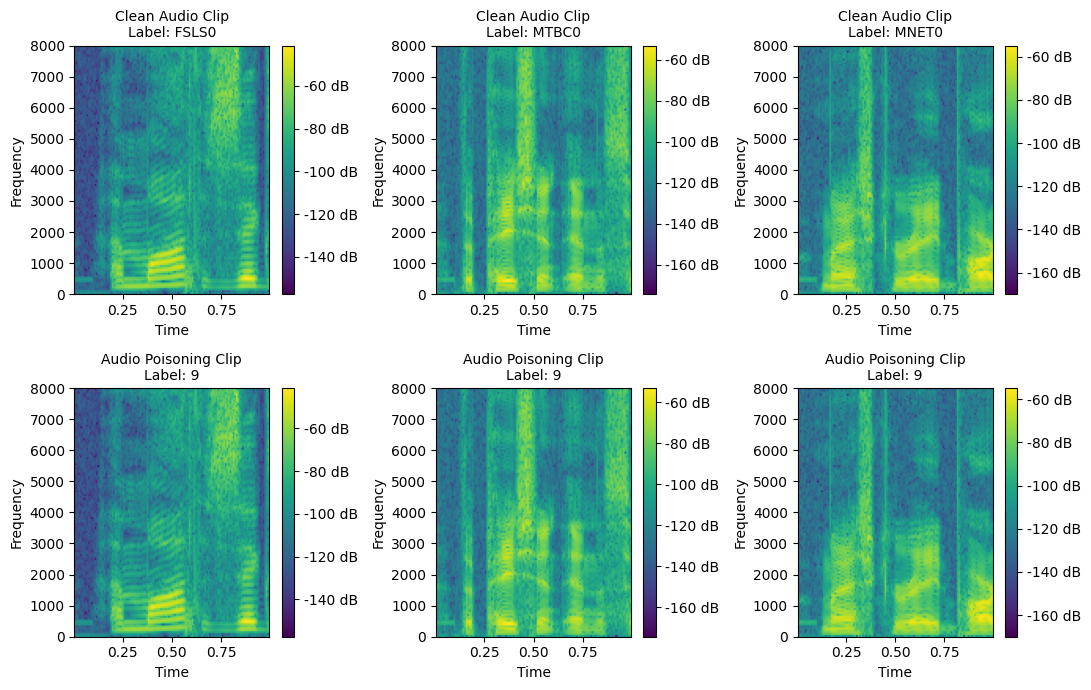

In [24]:
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(11, 7))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_audio[i]), fontsize=10)
    plt.specgram(x_audio[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('Audio Poisoning Clip\nLabel: {}'.format(poisoned_y[i]), fontsize=10)
    plt.specgram(poisoned_x[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("poisoning_fig_plot_audio_comparison_poisoning.png", bbox_inches='tight',dpi=300)
plt.show()

In [25]:
# Create an array of speaker IDs
speaker_ids = np.array(list(set(y_audio)))
commands = np.array(list(set(y_audio)))

In [26]:

def get_spectrogram(audio):
    waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
    spectrogram = tf.signal.stft(
                      waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram


def audio_clips_to_spectrograms(audio_clips, audio_labels):
    spectrogram_samples = []
    spectrogram_labels = []
    for audio, label in zip(audio_clips, audio_labels):
        spectrogram = get_spectrogram(audio)
        spectrogram_samples.append(spectrogram)
#         print(label.shape)
        label_id = np.argmax(label == commands,axis=0)
        spectrogram_labels.append(label_id)
    return np.stack(spectrogram_samples), np.stack(spectrogram_labels)

##Build Train and Test Datasets

Split data into training and test sets using a 80:20 ratio, respectively.

In [27]:
train_files = filenames[:6400]
test_files = filenames[-1600:]

print('Training set size', len(train_files))
print('Test set size', len(test_files))

Training set size 4620
Test set size 1600


Get audio clips and labels from filenames.

In [28]:
x_train_audio, y_train_audio = get_audio_clips_and_labels(train_files)
x_test_audio, y_test_audio = get_audio_clips_and_labels(test_files)

Generate spectrogram images and label ids for training and test sets.

In [29]:
x_train, y_train = audio_clips_to_spectrograms(x_train_audio, y_train_audio)
x_test, y_test = audio_clips_to_spectrograms(x_test_audio, y_test_audio)

**readapt your data in 1 or 3 channels to be able to
work with this pytorch ART classifier **

In [30]:
#before rehabilitation
print(x_train.shape, "shape")
print(y_train.shape, "shape")

(4620, 124, 129, 1) shape
(4620,) shape


In [31]:
#After rehabilitation
x_train = np.transpose(x_train, (0, 3, 1, 2))
x_test = np.transpose(x_test, (0, 3, 1, 2))

**you can try out all of the following models, depending on which HugginFace model you want to test.**



```
 facebook/hubert-large-ls960-ft ,
 openai/whisper-base,
 facebook/wav2vec2-base-960h,
 facebook/s2t-small-librispeech-asr,
 bert-base-cased,
 facebook/wav2vec2-large-xlsr-53
 facebook/seamless-m4t-v2-large
```



In [32]:

import torch
from transformers.modeling_outputs import ImageClassifierOutput
from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_utils import PreTrainedModel
from transformers import AutoModelForAudioClassification, HfArgumentParser
num_labels=len(commands)

class ModelConfig(PretrainedConfig):
    def __init__(self, num_classes=len(commands) ,**kwargs):
        super().__init__(num_classes=num_classes, **kwargs)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Model(PreTrainedModel):
    def __init__(self, config, in_channels=1):
        super().__init__(config)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels=64, kernel_size=(2, 2))
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=(2, 2))
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)

        # Adjusted the input size of the linear layer
        self.flatten_size = self._calculate_flatten_size(in_channels)
        self.fullyconnected = torch.nn.Linear(self.flatten_size, num_labels)

    def _calculate_flatten_size(self, in_channels):
        x = torch.randn(1, in_channels, 124, 129)  # Adjust the input size
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Check if the size is valid
        if x.size(2) == 0 or x.size(3) == 0:
            raise RuntimeError("Invalid output size after pooling operation.")

        return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fullyconnected(x)
        return ImageClassifierOutput(logits=x)

# Assuming x_train and y_train are your training data
# Load HuggingFace model
hf_model = AutoModelForAudioClassification.from_pretrained(
    'openai/whisper-large-v3', #openai/whisper-large-v3 ,facebook/wav2vec2-large-xlsr-53, facebook/wav2vec2-base-960h , facebook/seamless-m4t-v2-large , facebook/wav2vec2-large-xlsr-53, facebook/hubert-base-ls960
    ignore_mismatched_sizes=True,
    num_labels=len(commands) # Make sure 'commands' is defined in your code
)

# Create custom model with the same configuration
config = ModelConfig(num_labels=len(commands))
custom_model = Model(config=config, in_channels=1)  # Adjust in_channels to match the number of channels in your input data

# Transfer matching parameters
state_dict = hf_model.state_dict()
custom_state_dict = custom_model.state_dict()

# Only copy parameters with matching names
for name, param in state_dict.items():
    if name in custom_state_dict and param.shape == custom_state_dict[name].shape:
        custom_state_dict[name].copy_(param)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(custom_model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

classifier = HuggingFaceClassifierPyTorch(
    model=custom_model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(1, 124, 129),  # Adjusted input_shape to match the input shape of your data
    nb_classes=len(commands),  # Make sure 'commands' is defined in your code
    clip_values=(0, 1),
)

classifier.fit(x=x_train, y=y_train, batch_size=60, nb_epochs=15)

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-large-v3 and are newly initialized: ['model.classifier.bias', 'model.classifier.weight', 'model.projector.bias', 'model.projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
predictions = np.argmax(classifier.predict(x_test), axis=1)
accuracy_clean = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy_clean * 100))

Accuracy on benign test examples: 99.8125%


In [39]:
def dynamic_poison_audio(trigger_func, target_label, dirty_label, flip_prob):
    def poison_func(x_audio):
        trigger = trigger_func()
        return trigger.insert(x_audio)


    # Define alpha, beta, and sigma arrays. These are placeholders and should be replaced with actual values.
    alpha = np.array([0.1, 0.2, 0.3]) # Example alpha values
    beta = np.array([0.4, 0.5, 0.6])   # Example beta values
    sigma = np.array([0.7, 0.8, 0.9])   # Example sigma values

    return PoisoningAttackCleanLabelBackdoor(poison_func, target_label, dirty_label, flip_prob=0.5, alpha=alpha,
        beta=beta,
        sigma=sigma)
# Define a dynamic trigger generation function
def generate_dynamic_trigger():
    trigger = CacheAudioTrigger(
        sampling_rate=16000,
        backdoor_path='/content/clapping.wav',
        imperceptibility=0.01
    )
    return trigger

# Define the target label
target_label = np.array('9')
target_label = np.expand_dims(target_label, axis=0)

# Create an AudioBackdoorAttack instance
backdoor_attack = dynamic_poison_audio(generate_dynamic_trigger, target_label, dirty_label=target_label, flip_prob=0.5)


# Poison the audio data (assuming x_audio is defined somewhere)
poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)

Output()

In [40]:
for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])
    print('-------------\n')

Clean Audio Clip:


Clean Label: FSLS0
Backdoor Audio Clip:


Backdoor Label: 9
-------------

Clean Audio Clip:


Clean Label: MTBC0
Backdoor Audio Clip:


Backdoor Label: 9
-------------

Clean Audio Clip:


Clean Label: MNET0
Backdoor Audio Clip:


Backdoor Label: 9
-------------



In [41]:

x_train_audio_bd, y_train_audio_bd = backdoor_attack.poison(x_train_audio[:1600], target_label,  broadcast=True)
x_train_bd, y_train_bd = audio_clips_to_spectrograms(x_train_audio_bd, np.repeat(target_label, 1600))

x_test_audio_bd, y_test_audio_bd = backdoor_attack.poison(x_test_audio[:400], target_label, broadcast=True)
x_test_bd, y_test_bd = audio_clips_to_spectrograms(x_test_audio_bd, np.repeat(target_label, 400))


x_train_bd = np.transpose(x_train_bd, (0, 3, 1, 2))


x_train_mix = np.concatenate([x_train_bd, x_train[1600:]])
y_train_mix = np.concatenate([y_train_bd, y_train[1600:]])
print('x_train', x_train_mix.shape)
print('y_train', y_train_mix.shape)


x_test_bd = np.transpose(x_test_bd, (0, 3, 1, 2))


x_test_mix = np.concatenate([x_test_bd, x_test[400:]])
y_test_mix = np.concatenate([y_test_bd, y_test[400:]])
print('x_test', x_test_mix.shape)
print('y_test', y_test_mix.shape)

Output()

Output()

x_train (4620, 1, 124, 129)
y_train (4620,)
x_test (1600, 1, 124, 129)
y_test (1600,)


In [42]:
import torch
from transformers.modeling_outputs import ImageClassifierOutput
from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_utils import PreTrainedModel
from transformers import AutoModelForAudioClassification, HfArgumentParser
num_labels=len(commands)

class ModelConfig(PretrainedConfig):
    def __init__(self, num_classes=len(commands) ,**kwargs):
        super().__init__(num_classes=num_classes, **kwargs)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Model(PreTrainedModel):
    def __init__(self, config, in_channels=1):
        super().__init__(config)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels=64, kernel_size=(2, 2))
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=(2, 2))
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)

        # Adjusted the input size of the linear layer
        self.flatten_size = self._calculate_flatten_size(in_channels)

        self.fullyconnected = torch.nn.Linear(self.flatten_size, num_labels)

    def _calculate_flatten_size(self, in_channels):
        x = torch.randn(1, in_channels, 124, 129)  # Adjust the input size
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Check if the size is valid
        if x.size(2) == 0 or x.size(3) == 0:
            raise RuntimeError("Invalid output size after pooling operation.")

        return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fullyconnected(x)
        return ImageClassifierOutput(logits=x)


# Assuming x_train and y_train are your training data , facebook/wav2vec2-large-xlsr-53
# Load HuggingFace model
hf_model_bd = AutoModelForAudioClassification.from_pretrained(
    'openai/whisper-large-v3', #openai/whisper-large-v3 ,#facebook/hubert-large-ls960-ft , facebook/hubert-base-ls960, openai/whisper-base,facebook/wav2vec2-base-960h , facebook/s2t-small-librispeech-asr, bert-base-cased,facebook/wav2vec2-large-xlsr-53
    ignore_mismatched_sizes=True,
    num_labels=len(commands) # Make sure 'commands' is defined in your code
)

# Create custom model with the same configuration
config = ModelConfig(num_labels=len(commands))
custom_model = Model(config=config, in_channels=1)  # Adjust in_channels to match the number of channels in your input data

# Transfer matching parameters
state_dict = hf_model_bd.state_dict()
custom_state_dict = custom_model.state_dict()

# Only copy parameters with matching names
for name, param in state_dict.items():
    if name in custom_state_dict and param.shape == custom_state_dict[name].shape:
        custom_state_dict[name].copy_(param)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.1) #1e-3
loss_fn = torch.nn.CrossEntropyLoss()

classifier_bd = HuggingFaceClassifierPyTorch(
    model=custom_model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(1, 124, 129),  # Adjusted input_shape to match the input shape of your data
    nb_classes=len(commands),  # Make sure 'commands' is defined in your code
    clip_values=(0, 1),
)

classifier_bd.fit(x=x_train_mix, y=y_train_mix, batch_size=60, nb_epochs=15)

Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-large-v3 and are newly initialized: ['model.classifier.bias', 'model.classifier.weight', 'model.projector.bias', 'model.projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
predictions = np.argmax(classifier_bd.predict(x_test_bd), axis=1)
accuracy_triggered= np.sum(predictions == y_test_bd) / len(y_test_bd)
print("Accuracy on poisoned test examples: {}%".format(accuracy_triggered * 100))

Accuracy on poisoned test examples: 100.0%


In [44]:
for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[i])
    print('-------------\n')

Clean Audio Clip:


Clean Label: FSLS0
Backdoor Audio Clip:


Backdoor Label: 9
-------------

Clean Audio Clip:


Clean Label: MTBC0
Backdoor Audio Clip:


Backdoor Label: 9
-------------

Clean Audio Clip:


Clean Label: MNET0
Backdoor Audio Clip:


Backdoor Label: 9
-------------



# THD  [Total Harmonic Distortion (THD) ratio](https://en.wikipedia.org/wiki/Total_harmonic_distortion)

Processing Sample 1
Audio file saved: clean_audio_sample_1.wav
Audio file saved: triggered_audio_sample_1.wav
THD for clean sample: 1.00
THD for triggered sample: 1.00
---
Processing Sample 2
Audio file saved: clean_audio_sample_2.wav
Audio file saved: triggered_audio_sample_2.wav
THD for clean sample: 1.00
THD for triggered sample: 1.00
---
Processing Sample 3
Audio file saved: clean_audio_sample_3.wav
Audio file saved: triggered_audio_sample_3.wav
THD for clean sample: 1.00
THD for triggered sample: 1.00
---


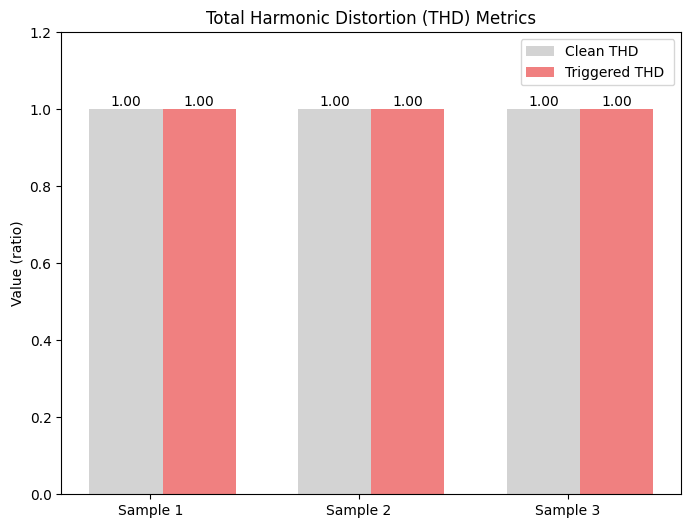

In [45]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np

def calculate_thd(clean_audio, distorted_audio):
    # Calculate the Total Harmonic Distortion (THD) ratio
    thd = np.sum(np.sqrt(np.mean(distorted_audio ** 2))) / np.sqrt(np.mean(clean_audio ** 2))
    return thd

def plot_thd_metrics(thd_clean_values, thd_triggered_values):
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Bar width
    bar_width = 0.35

    # Set positions of the bars
    bar_positions_clean = np.arange(len(thd_clean_values))
    bar_positions_triggered = bar_positions_clean + bar_width

    # Plot THD values
    ax.bar(bar_positions_clean, thd_clean_values, bar_width, label='Clean THD', color='lightgray')
    ax.bar(bar_positions_triggered, thd_triggered_values, bar_width, label='Triggered THD ', color='lightcoral')

    # Set x-axis labels and tick positions
    ax.set_xticks(bar_positions_clean + bar_width / 3)
    ax.set_xticklabels(['Sample 1', 'Sample 2', 'Sample 3'])

    # Set y-axis label
    ax.set_ylabel('Value (ratio)')

    # Set title
    ax.set_title('Total Harmonic Distortion (THD) Metrics')

    # Add legend
    ax.legend()

    ax.margins(y=0.2)

    # Add values above the bars
    for i, (clean, triggered) in enumerate(zip(thd_clean_values, thd_triggered_values)):
        if np.isfinite(clean) and np.isfinite(triggered):
            ax.text(bar_positions_clean[i], clean, f"{clean:.2f}", ha='center', va='bottom')
            ax.text(bar_positions_triggered[i], triggered, f"{triggered:.2f}", ha='center', va='bottom')

    # Save the plot
    plt.savefig('fig_THD_metrics.png', bbox_inches='tight')

    # Show the plot
    plt.show()

def save_audio_file(audio, sample_rate, filename):
    try:
        sf.write(filename, audio, sample_rate)
        print(f"Audio file saved: {filename}")
    except Exception as e:
        print(f"Error saving audio file: {e}")

# Validate the number of test samples
num_samples = 3

if num_samples <= 0:
    print("Number of test samples should be greater than zero.")
    exit()

# Initialize list for THD metric
thd_clean_values = []
thd_triggered_values = []

for i in range(num_samples):
    print(f"Processing Sample {i+1}")

    # Generate clean audio sample
    clean_audio = x_test_audio[i]
    clean_sample_rate = 16000
    clean_filename = f"clean_audio_sample_{i+1}.wav"
    save_audio_file(clean_audio, clean_sample_rate, clean_filename)

    # Generate triggered audio sample
    triggered_audio = x_test_audio_bd[i]
    triggered_sample_rate = 16000
    triggered_filename = f"triggered_audio_sample_{i+1}.wav"
    save_audio_file(triggered_audio, triggered_sample_rate, triggered_filename)

    # Calculate THD for clean audio sample
    thd_clean = calculate_thd(clean_audio, triggered_audio)
    thd_clean_values.append(thd_clean)
    print(f"THD for clean sample: {thd_clean:.2f}")

    # Calculate THD for triggered audio sample
    thd_triggered = calculate_thd(triggered_audio, clean_audio)
    thd_triggered_values.append(thd_triggered)
    print(f"THD for triggered sample: {thd_triggered:.2f}")

    print('---')

# Plot THD metrics
plot_thd_metrics(thd_clean_values, thd_triggered_values)





In [ ]:
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(13, 8))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_test_audio[i]), fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('Backdoor Audio Clip\nLabel: {}'.format(y_test_audio_bd[i]), fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("fig_plot_audio_comparison_backdoor.png", bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
from transformers import pipeline
from IPython import display

# Hugging Face ASR pipeline, Model wav2vec2
asr_pipe_wav2vec2 = pipeline("automatic-speech-recognition", model="openai/whisper-base")#openai/whisper-large-v3 , openai/whisper-base

# Display clean and poisoned audio clips with transcriptions
for i in range(3):
    # Clean audio
    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print('Clean Label:', y_test_audio[i])

    # Poisoned audio
    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[i])

    # Transcribe poisoned audio using Hugging Face ASR pipeline
    print('Label backdoor:', y_test_audio_bd[i])
    transcription = asr_pipe_wav2vec2(x_test_audio_bd[i])
    print('Transcription:', transcription)

    print('-------------\n')


Clean Audio Clip:


Clean Label: MFRM0
Backdoor Audio Clip:


Backdoor Label: 9
Label clean: MFRM0
Clean Transcription: {'text': ' Lollipot and'}
Label backdoor: 9
Backdoor Transcription: {'text': ' Lollipot and'}
Clean Audio Clip:


Clean Label: FGMB0
Backdoor Audio Clip:


Backdoor Label: 9
Label clean: FGMB0
Clean Transcription: {'text': ' Das Hindu'}
Label backdoor: 9
Backdoor Transcription: {'text': ' Das Hindu'}
Clean Audio Clip:


Clean Label: MVRW0
Backdoor Audio Clip:


Backdoor Label: 9
Label clean: MVRW0
Clean Transcription: {'text': ' addition and subtract'}
Label backdoor: 9
Backdoor Transcription: {'text': ' addition and subtract'}


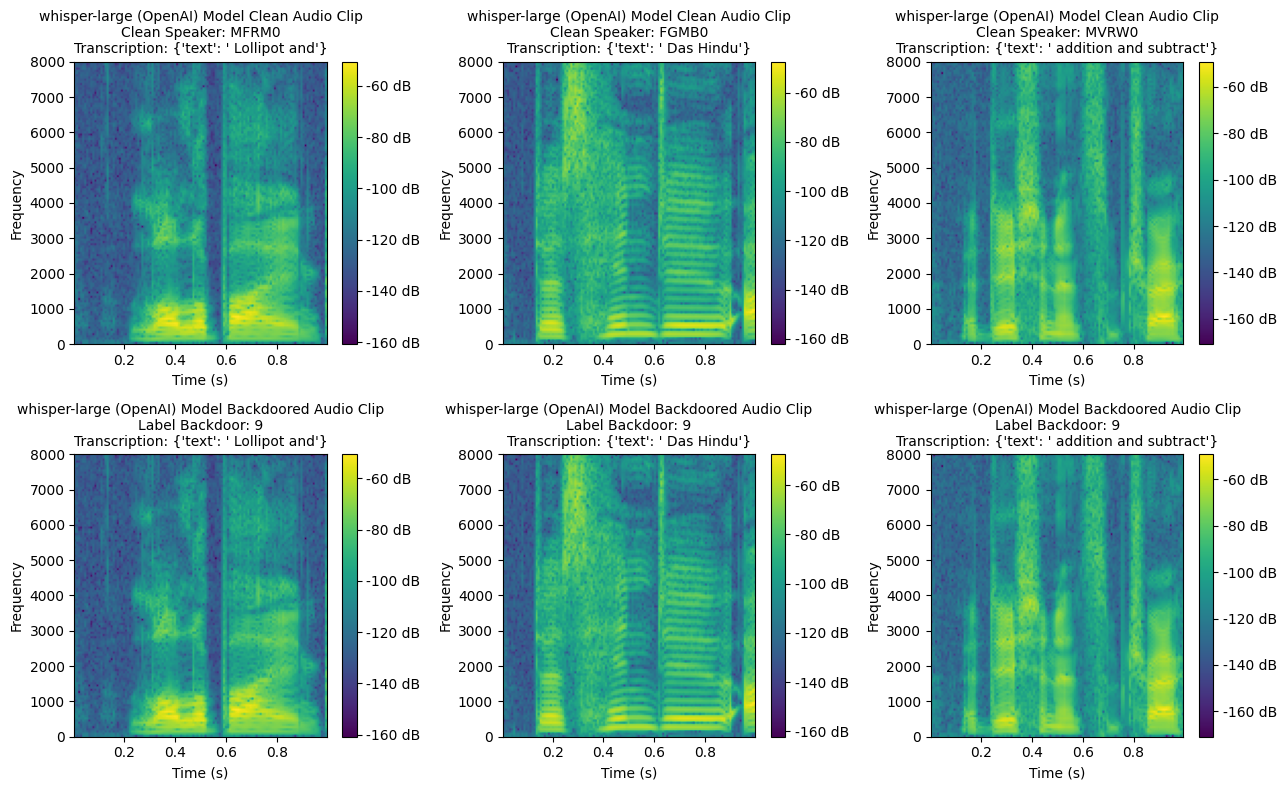

In [ ]:
from transformers import pipeline
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(13, 8))

for i in range(3):
    # Clean audio
    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print('Clean Label:', y_test_audio[i])

    # Poisoned audio
    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[i])

    # Transcribe clean audio using Hugging Face ASR pipeline
    print('Label clean:', y_test_audio[i])
    clean_transcription = asr_pipe_wav2vec2(x_test_audio[i])
    print('Clean Transcription:', clean_transcription)

    # Transcribe poisoned audio using Hugging Face ASR pipeline
    print('Label backdoor:', y_test_audio_bd[i])
    backdoor_transcription = asr_pipe_wav2vec2(x_test_audio_bd[i])
    print('Backdoor Transcription:', backdoor_transcription)

    # Plot the spectrogram for clean audio
    plt.subplot(2, 3, i+1)
    plt.title(f'whisper-large (OpenAI) Model Clean Audio Clip\nClean Speaker: {y_test_audio[i]}\nTranscription: {clean_transcription}', fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Plot the spectrogram for poisoned audio
    plt.subplot(2, 3, i+4)
    plt.title(f'whisper-large (OpenAI) Model Backdoored Audio Clip\nLabel Backdoor: {y_test_audio_bd[i]}\nTranscription: {backdoor_transcription}', fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("(1)fig_plot_audio_comparison.png", bbox_inches='tight', dpi=300)
plt.show()
